In [7]:
import os
import sys
import pickle

import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from pathlib import Path

PROJECT_ROOT = "/home/tom/Documents/UNT/csce6260/projects/OpenPCDet"
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

In [2]:
data_dir = Path("/home/tom/Documents/UNT/csce6260/projects/pcdet_notebooks/data")
sample_file_path = "sample_000000.pkl"
sample_file_path = data_dir / sample_file_path

with open(sample_file_path, "rb") as f:
    sample = pickle.load(f)

print("Sample keys:", sample.keys())

Sample keys: dict_keys(['frame_id', 'calib', 'gt_boxes', 'gt_boxes2d', 'points', 'images', 'points_2d', 'flip_x', 'noise_rot', 'noise_scale', 'lidar_aug_matrix', 'use_lead_xyz', 'image_shape'])


In [3]:
points = sample['points']

print("Points shape:", points.shape)
print('Min/Max values for all dimensions')
min_x, max_x = np.min(points[:, 0]), np.max(points[:, 0])
min_y, max_y = np.min(points[:, 1]), np.max(points[:, 1])
min_z, max_z = np.min(points[:, 2]), np.max(points[:, 2])
print(f"X: ({min_x:.2f}, {max_x:.2f})")
print(f"Y: ({min_y:.2f}, {max_y:.2f})")
print(f"Z: ({min_z:.2f}, {max_z:.2f})")

Points shape: (16384, 4)
Min/Max values for all dimensions
X: (4.21, 61.66)
Y: (-28.13, 13.06)
Z: (-2.06, 1.97)


In [9]:
CLASS_COLORS = {
    1: (1, 0, 0),    # Car     (red)
    2: (0, 1, 0),    # Pedestrian (green)
    3: (0, 0, 1)     # Cyclist (blue)
}

def get_point_colors(z):
    z_norm = (z - z.min()) / (z.max() - z.min() + 1e-6)
    colors = plt.cm.jet(z_norm)[:, :3]
    return colors

def create_point_cloud(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    colors = get_point_colors(points[:, 2])
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def get_gt_oriented_bounding_boxes(gt_boxes):
    boxes = []
    for box in gt_boxes:
        x, y, z, dx, dy, dz, heading, class_idx = box
        class_idx = int(class_idx)
        obb = o3d.geometry.OrientedBoundingBox(
            center=[0, 0, 0],
            R=o3d.geometry.get_rotation_matrix_from_xyz([0, 0, heading]),
            extent=[dx, dy, dz]
        )
        obb.translate([x, y, z])
        obb.color = CLASS_COLORS.get(class_idx, (1, 1, 1))
        boxes.append(obb)
    return boxes


points = sample['points'][:, :3]
pcd = create_point_cloud(points)
gt_boxes = get_gt_oriented_bounding_boxes(sample['gt_boxes'])
o3d.visualization.draw_geometries([pcd, *gt_boxes])

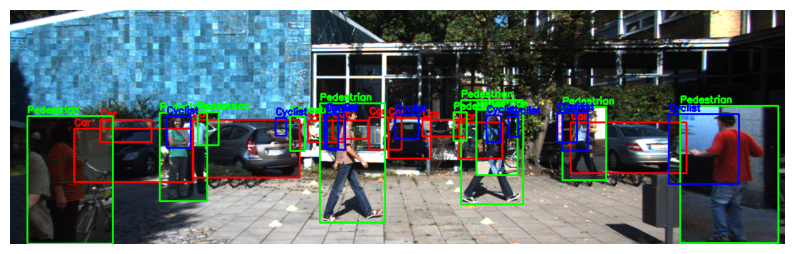

In [8]:
def draw_gt_boxes(image, boxes2d, class_ids, class_names):
    img = image.copy()
    for (xmin, ymin, xmax, ymax), cid in zip(boxes2d, class_ids):
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        label = class_names[cid - 1]
        color_rgb = CLASS_COLORS.get(cid, (1, 1, 1))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color_rgb, 2)
        cv2.putText(img, label, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_rgb, 2)
    return img


image = sample['images']
boxes2d = sample['gt_boxes2d']
class_ids = sample['gt_boxes'][:, -1].astype(int)
class_names = ['Car', 'Pedestrian', 'Cyclist']

drawn = draw_gt_boxes(image, boxes2d, class_ids, class_names)

plt.figure(figsize=(10,6))
plt.imshow(drawn)
plt.axis("off")
plt.show()